In [17]:
 import pandas as pd
import seaborn as sns
import numpy as np
import csv
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, metrics, optimizers, utils, initializers
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras import layers, models, metrics, optimizers, utils
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

# Fingerprinting - 3 classes -1 Server

In this notebook, we are doing fingerprinting on BLE packets, meaning that we are trying to identify an emitter based on the traffic it emits. We are using data from Scenario 5, in which the emitter and the server are still, using 3 nRF52 dev kits used as BLE advertising devices, 4 USRPs used as receivers. We are using raw IQ data as input. 
We are using data solely from Scene 31, where 3 emitters are advertising at the same time. This means that we now have 3 classes. We are using data solely from one server.

In [18]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [19]:

idata=pd.read_csv('../data/processed/scenario5_scene31.csv')
idata=idata.dropna(subset=['Robot_node'])


In [20]:
print(idata['Server_id'].value_counts())

print(idata['Len Packet'].value_counts())

11    955920
9     886400
12    663040
15    595520
Name: Server_id, dtype: int64
1520    3011120
1360      89760
Name: Len Packet, dtype: int64


In [21]:
#selecting data from server 11 only and with pkt len=1520
#idata=idata[idata['Server_id']==11]

idata=idata[idata['Len Packet']==1520]
print(len(idata.index))

3011120


## Creating Neural Network input

We are creating input for the CNN: X is composed of 1520 IQ samples, and Y is the scene number, meaning the emitter used in each of these scenes. The input data, i.e. the IQ data are normalized.

In [22]:

scaler = MinMaxScaler(feature_range=(0, 1))
idata[['real','im']]=scaler.fit_transform(idata[['real','im']].values)

### Use the whole packet as input

In [23]:
def input_whole_pkt(idata):
    #creating input for CNN: IQ values for a whole pkt     output: robot_node
    X=list()
    Y=list()

    pkt_len=1520

    i=0
    while i<len(idata.index):
        data=idata.iloc[i:i+pkt_len]
        if len(data['Time'].unique())==1:
            data=np.array(data[['real','im']], dtype='float64')
            x=data.reshape(pkt_len,2)
            X.append(x)
            Y.append(int(idata.iloc[i]['Robot_node']))  
        else:
            print('Missing!!')
        i=i+pkt_len

    X=np.array(X)
    Y=np.array(Y, dtype=int)

    input_shape=(pkt_len,2)
    batch_size=10
    
    print("Il y a "+str(len(Y))+" échantillons")
    
    return (X, Y, input_shape, batch_size)

### Use only part of the packet as input

In [24]:
def input_part_pkt(idata):
    #creating input for CNN: IQ values for a whole pkt     output: robot_node
    X=list()
    Y=list()
    pkt_len=1520
    i=0
    while i<len(idata.index):
        data=idata.iloc[i+744:i+944]
        if len(data['Time'].unique())==1:
            data=np.array(data[['real','im']], dtype='float64')
            x=data.reshape((200),2)
            X.append(x)
            Y.append(int(idata.iloc[i]['Robot_node']))  
        else:
            print('Missing!!')
        i=i+pkt_len

    X=np.array(X)
    Y=np.array(Y, dtype=int)
    
    batch_size=10
    input_shape=(200,2)
    
    print("Il y a "+str(len(Y))+" échantillons")
    
    return (X, Y, input_shape, batch_size)

### Creates overlapping slices of each packet and gather them into a batch

In [25]:
def input_slices_pkt(idata):
    #creating input for CNN: IQ values for a whole pkt     output: robot_node
    X=list()
    Y=list()
    pkt_len=1520
    i=0
    while i<len(idata.index):
        data=idata.iloc[i:i+pkt_len]
        if len(data['Time'].unique())==1:
            data=np.array(data[['real','im']], dtype='float64')
            x=data.reshape((pkt_len),2)
            #creates slices of the packet and gather them in a single batch
            x=tf.data.Dataset.from_tensor_slices(x)
            x = x.window(500, 250, 1, True)
            count=0
            for window in x:
                X.append(list(window.as_numpy_iterator()))
                count=count+1

            Y.append(int(idata.iloc[i]['Robot_node']))  
        else:
            print('Missing!!')
        i=i+pkt_len

    X=np.array(X)
    Y=np.array(Y, dtype=int)

    input_shape=X[0].shape
    batch_size=count
    
    print("Il y a "+str(len(Y))+" échantillons")
    
    return (X, Y, input_shape, batch_size)

## Balancing classes

We are manually balancing the classes to make classification easier and avoid bias due to class imbalance.

In [26]:
def balance_classes(X,Y):
    unique_elements, counts_elements = np.unique(Y, return_counts=True)


    #balance classes
    min_samples=min(counts_elements)


    thirty_five_index=np.where(Y == 1.0)
    thirty_five_index=thirty_five_index[0][:min_samples]
    X_thirty_five=X[thirty_five_index]
    Y_thirty_five=Y[thirty_five_index]

    thirty_six_index=np.where(Y == 2.0)
    thirty_six_index=thirty_six_index[0][:min_samples]
    X_thirty_six=X[thirty_six_index]
    Y_thirty_six=Y[thirty_six_index]

    thirty_seven_index=np.where(Y == 3.0)
    thirty_seven_index=thirty_seven_index[0][:min_samples]
    X_thirty_seven=X[thirty_seven_index]
    Y_thirty_seven=Y[thirty_seven_index]

    X=np.concatenate((X_thirty_five, X_thirty_six, X_thirty_seven))
    Y=np.concatenate((Y_thirty_five, Y_thirty_six, Y_thirty_seven))

    print(np.unique(Y, return_counts=True))
    return (X,Y)

We are attributing a class number (0,1,2) to each scene: 1 is 0, 2 is 1 and 3 is 2.

In [27]:
def name_classes(Y):
    Y_change=list()

    #35:0, 36:1 37:2
    for i in Y:
        if i==1.0:
            Y_change.append(0)
        elif i==2.0:
            Y_change.append(1)
        elif i==3.0:
            Y_change.append(2)

    Y_change=np.array(Y_change)
    
    return Y_change

In [28]:
def data_preparation_nn(idata, type_input):
    if type_input=='whole':
        X,Y,input_shape,batch_size=input_whole_pkt(idata)
    elif type_input=='part':
        X,Y,input_shape,batch_size=input_part_pkt(idata)
    elif type_input=='slice':
        X,Y,input_shape,batch_size=input_slices_pkt(idata)
   
    X,Y=balance_classes(X,Y)
    Y_change=name_classes(Y)
    
    unique_elements, counts_elements = np.unique(Y_change, return_counts=True)
    nb_class=max(unique_elements)+1
        
    Y_cat=utils.to_categorical(Y_change, num_classes=nb_class)

    X_train, X_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.2, random_state=54)
    return(X_train, X_test, y_train, y_test, input_shape, batch_size)

In [29]:
def plot_accuracy(history):
    i = np.arange(len(history.history['loss']))
    plt.xlabel('Step')
    plt.ylabel('Accuracy')
    plt.plot(i, history.history['accuracy'], label='accuracy')
    plt.plot(i, history.history['val_accuracy'], label='val_accuaracy')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

In [30]:
def test_metrics(model, y_test, X_test):
    predictions= model.predict(X_test)
    predictions = [np.argmax(y, axis=0, out=None) for y in predictions]
    y_test_cat = [np.argmax(y, axis=0, out=None) for y in y_test]
    
    present_class_list=np.unique(y_test_cat)

    # Confusion Matrix
    conf_mat=confusion_matrix(y_test_cat, predictions, labels=present_class_list)

    #F1-score
    print("f1_score for each class")
    f1_each=f1_score(y_test_cat, predictions, average=None, labels=present_class_list)
    print(f1_each)

    #F1-score
    print("Global f1_score")
    print(f1_score(y_test_cat, predictions, average='weighted'))

    #accyracy
    print("Global accuracy")
    print(accuracy_score(y_test_cat,predictions))

    import seaborn as sns
    cmap = sns.diverging_palette(200, 10, as_cmap=True)
    sns.heatmap(conf_mat, cmap=cmap, xticklabels=present_class_list, yticklabels=present_class_list)

## CNN 1 / AlexNet 1D

We are now trying a feedforward CNN, inspired by the one in the following article: "More is better: Data Augmentation for channel-Resilient RF Fingerprinting" by Nasim Soltani. It is also described in "RF Fingerprinting Unnanned Aerial Vehicles with Non-Standard Transmitter Waveforms", in which it is called AlexNet1D.

| CNN 1 type | Test Accuracy | Comments |
| --- | --- | --- |
|Tuned version+ input slice (200 samples shift 50)| 0.33 |Overfits|
| --- | --- | --- |
|Tuned version+ whole pkt)| 0.35 |Overfits|
| --- | --- | --- |
|Tuned version+ part pkt 200 samples| 0.33 |Overfits|
| --- | --- | --- |
|Tuned version+ input slice (1000 samples shift 50)| 0.27 |Overfits|
| --- | --- | --- |
|Tuned version+ input slice (500 samples shift 250)| 0.39 |Overfits|


In [31]:
X_train, X_test, y_train, y_test, input_shape, batch_size=data_preparation_nn(idata, 'slice')

steps=300
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=100)

model = models.Sequential()
model.add(layers.BatchNormalization(input_shape=input_shape))
model.add(layers.GaussianNoise(0.1,input_shape=input_shape))

for i in range(3):
    model.add(layers.Conv1D(filters=60, kernel_size=(2), padding='valid',activation='relu'))
    model.add(layers.Conv1D(filters=120, kernel_size=(8), padding='valid',activation='tanh'))
    model.add(layers.MaxPooling1D((2)))

model.add(layers.Dense(units=200))
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=800))
#model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer=optimizers.Adam(learning_rate = 0.0001),
          loss=tf.keras.losses.categorical_crossentropy,
          metrics=['accuracy'])

history=model.fit(X_train, y_train, batch_size=batch_size, epochs=steps, verbose=1, validation_split=0.2,
                 callbacks=[callback])


Il y a 1981 échantillons
(array([1, 2, 3]), array([594, 594, 594]))
Epoch 1/300
228/228 [==============================] - 2s 10ms/step - loss: 1.1003 - accuracy: 0.3439 - val_loss: 1.0994 - val_accuracy: 0.3228
Epoch 2/300
228/228 [==============================] - 2s 7ms/step - loss: 1.0922 - accuracy: 0.3640 - val_loss: 1.1001 - val_accuracy: 0.3298
Epoch 3/300
228/228 [==============================] - 2s 7ms/step - loss: 1.0810 - accuracy: 0.3798 - val_loss: 1.0957 - val_accuracy: 0.3263
Epoch 4/300
228/228 [==============================] - 2s 7ms/step - loss: 1.0488 - accuracy: 0.4079 - val_loss: 1.1034 - val_accuracy: 0.3228
Epoch 5/300
228/228 [==============================] - 2s 7ms/step - loss: 1.0048 - accuracy: 0.4316 - val_loss: 1.1256 - val_accuracy: 0.3088
Epoch 6/300
228/228 [==============================] - 2s 7ms/step - loss: 0.9693 - accuracy: 0.4518 - val_loss: 1.1337 - val_accuracy: 0.3333
Epoch 7/300
228/228 [==============================] - 2s 7ms/step - loss

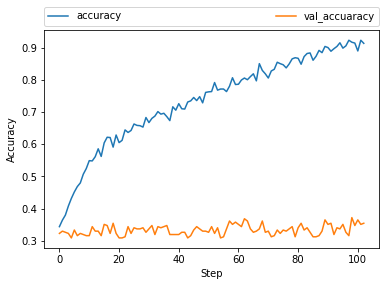

f1_score for each class
[0.34361233 0.34782609 0.30769231]
Global f1_score
0.33296656661574364
Global accuracy
0.3333333333333333


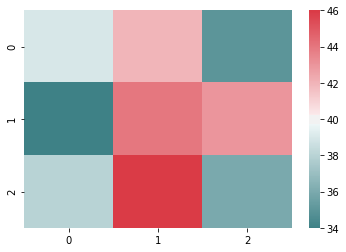

In [32]:
plot_accuracy(history)
test_metrics(model, y_test, X_test)

## CNN 2

| CNN 1 type | Test Accuracy | Comments |
| --- | --- | --- |
| Initial | 0.39 | Overfits a lot|
| --- | --- | --- |
| Initial + 200 samples part | 0.40 | Overfits a lot|
| --- | --- | --- |
| Initial + Slices (200, shift=150)| 0.46 | Overfits a little less|
| --- | --- | --- |
| Initial + Slices (200, shift=150)| 0.57 | Almost no overfitting|
| --- | --- | --- |
| Tuned version| 0.71 | Almost no overfitting|


We are now trying a more complex CNN, also described in the same article.

In [54]:
#X_train, X_test, y_train, y_test, input_shape, batch_size=data_preparation_nn(idata, 'slice')

steps=300

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=100)

model = models.Sequential()
model.add(layers.BatchNormalization(input_shape=input_shape))
model.add(layers.GaussianNoise(0.1))
for i in range(3):
    model.add(layers.Conv1D(filters=60, kernel_size=(2), padding='valid',activation='relu'))
    model.add(layers.MaxPooling1D((2)))
    model.add(layers.Dense(units=300))


model.add(layers.Dense(units=750))

model.add(layers.Flatten())          
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer=optimizers.Adam(learning_rate = 0.0001),
          loss=tf.keras.losses.categorical_crossentropy,
          metrics=['accuracy'])

history=model.fit(X_train, y_train, batch_size=batch_size, epochs=steps, verbose=1, validation_split=0.2,
                 callbacks=[callback])


Epoch 1/300
52/52 [==============================] - 10s 191ms/step - loss: 1.1113 - accuracy: 0.3222 - val_loss: 1.0985 - val_accuracy: 0.3297
Epoch 2/300
52/52 [==============================] - 0s 8ms/step - loss: 1.0859 - accuracy: 0.3611 - val_loss: 1.0989 - val_accuracy: 0.3187
Epoch 3/300
52/52 [==============================] - 0s 8ms/step - loss: 1.0713 - accuracy: 0.4111 - val_loss: 1.0981 - val_accuracy: 0.3626
Epoch 4/300
52/52 [==============================] - 0s 8ms/step - loss: 1.0358 - accuracy: 0.4500 - val_loss: 1.0976 - val_accuracy: 0.3516
Epoch 5/300
52/52 [==============================] - 0s 8ms/step - loss: 0.9764 - accuracy: 0.4694 - val_loss: 1.0980 - val_accuracy: 0.3297
Epoch 6/300
52/52 [==============================] - 0s 8ms/step - loss: 0.9122 - accuracy: 0.4944 - val_loss: 1.1019 - val_accuracy: 0.3516
Epoch 7/300
52/52 [==============================] - 0s 9ms/step - loss: 0.8516 - accuracy: 0.5361 - val_loss: 1.1070 - val_accuracy: 0.3407
Epoch 8/30

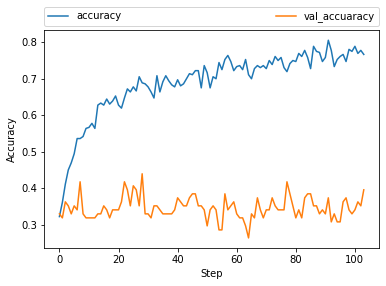

f1_score for each class
[0.37209302 0.30769231 0.32      ]
Global f1_score
0.33291813763515754
Global accuracy
0.336283185840708


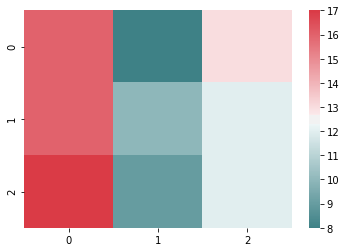

In [55]:
plot_accuracy(history)
test_metrics(model, y_test, X_test)

## Conv RNN

Let's now try out the third model described in the article, which is a Convolutional Recurrent Network.

| CNN 1 type | Test Accuracy | Comments |
| --- | --- | --- |
| Initial | 0.33 | Overfits a lot|
| --- | --- | --- |
| Initial + part (200 samples) | 0.40 | Overfits a lot|
| --- | --- | --- |
| Initial + Slices (200, shift:150)| 0.44 | Overfits a lot|
| --- | --- | --- |
| Initial + Slices (500, shift:50)| 0.57 | Overfits a little|
| --- | --- | --- |
| Tuned| 0.72 | Overfits a little|


In [56]:
#X_train, X_test, y_train, y_test, input_shape, batch_size=data_preparation_nn(idata, 'slice')

steps=300
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=100)


model = models.Sequential()
model.add(layers.BatchNormalization(input_shape=input_shape))
model.add(layers.GaussianNoise(0.1))
for i in range(2):
    model.add(layers.Conv1D(filters=430, kernel_size=(6), padding='valid',activation='tanh'))
    model.add(layers.MaxPooling1D((2)))


model.add(layers.SimpleRNN(units=400,activation="relu"))

model.add(layers.Dense(units=250))
model.add(layers.Dense(units=350))

model.add(layers.Flatten())          
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer=optimizers.Adam(learning_rate = 0.0001),
          loss=tf.keras.losses.categorical_crossentropy,
          metrics=['accuracy'])

history=model.fit(X_train, y_train, batch_size=batch_size, epochs=steps, verbose=1, validation_split=0.2,
                 callbacks=[callback])


Epoch 1/300
52/52 [==============================] - 13s 242ms/step - loss: 1.1281 - accuracy: 0.3111 - val_loss: 1.0995 - val_accuracy: 0.3297
Epoch 2/300
52/52 [==============================] - 4s 82ms/step - loss: 1.0756 - accuracy: 0.3833 - val_loss: 1.0982 - val_accuracy: 0.3297
Epoch 3/300
52/52 [==============================] - 4s 82ms/step - loss: 1.0690 - accuracy: 0.4028 - val_loss: 1.1000 - val_accuracy: 0.2967
Epoch 4/300
52/52 [==============================] - 4s 82ms/step - loss: 1.0480 - accuracy: 0.3972 - val_loss: 1.1015 - val_accuracy: 0.3077
Epoch 5/300
52/52 [==============================] - 4s 82ms/step - loss: 1.0249 - accuracy: 0.4583 - val_loss: 1.1059 - val_accuracy: 0.3077
Epoch 6/300
52/52 [==============================] - 4s 82ms/step - loss: 1.0033 - accuracy: 0.4472 - val_loss: 1.1103 - val_accuracy: 0.2967
Epoch 7/300
52/52 [==============================] - 4s 82ms/step - loss: 0.9906 - accuracy: 0.4306 - val_loss: 1.1123 - val_accuracy: 0.3407
Epoc

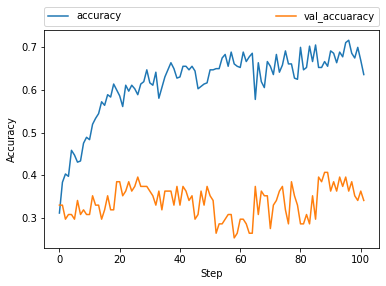

f1_score for each class
[0.3908046  0.44705882 0.22222222]
Global f1_score
0.35303052967703197
Global accuracy
0.37168141592920356


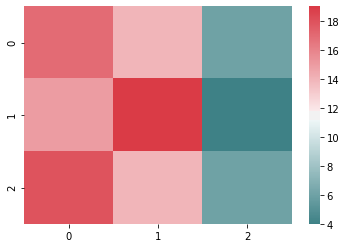

In [57]:
plot_accuracy(history)
test_metrics(model, y_test, X_test)

## ResNet 1D

| CNN 1 type | Test Accuracy | Comments |
| --- | --- | --- |
| Initial+BatchNorm+Gaussian Noise 0.1 (only blocks until 128)+ Slice input| 0.72 | Overfits a little|



In [15]:
def proj_block(x: tf.Tensor, filters):
    y_first = layers.Conv1D(kernel_size=1,
               filters=filters,
               padding="same", activation='relu')(x)
    y_first = layers.Conv1D(kernel_size=3,
               filters=filters,
               activation='relu')(y_first)
    y_first = layers.Conv1D(kernel_size=1,
               filters=4*filters,
               activation='relu')(y_first)
    
    y_second = layers.Conv1D(kernel_size=1,
               filters=4*filters,
               padding="same", activation='relu')(x)
    
    y = layers.concatenate([y_first,  y_second], axis=1)
    y = layers.Activation(activation='relu')(y)

    return y

In [16]:
def id_block(x: tf.Tensor, filters):
    y_first = layers.Conv1D(kernel_size=1,
               filters=filters,
               padding="same", activation='relu')(x)
    y_first = layers.Conv1D(kernel_size=3,
               filters=filters,
               activation='relu')(y_first)
    y_first = layers.Conv1D(kernel_size=1,
               filters=4*filters,
               activation='relu')(y_first)
    
    y = layers.concatenate([y_first,  x], axis=1)
    y = layers.Activation(activation='relu')(y)

    return y

In [17]:
X_train, X_test, y_train, y_test, input_shape, batch_size=data_preparation_nn(idata, 'slice')

Il y a 1089 échantillons
(array([35, 36, 37]), array([228, 228, 228]))


In [18]:

steps=300
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=100)

inputs = layers.Input(shape=input_shape)

t=layers.BatchNormalization()(inputs)
t=layers.GaussianNoise(0.1)(t)
t=layers.Conv1D(kernel_size=7,
               filters=64,
               activation='relu')(t)
t=layers.MaxPool1D(2)(t)
t=proj_block(t,64)
for i in range(2):
    t=id_block(t,64)

t=proj_block(t,128)
for j in range(3):
    t=id_block(t,128)
#t=proj_block(t,256)
#for k in range(1):
#    t=id_block(t,256)
#t=proj_block(t,512)  
#for l in range(2):
#    t=id_block(t,512)
t=layers.AveragePooling1D(2)(t)
t=layers.Flatten()(t)
outputs=layers.Dense(3,activation='softmax')(t)

model = tf.keras.models.Model(inputs, outputs)

model.compile(optimizer=optimizers.Adam(learning_rate = 0.0001),
          loss=tf.keras.losses.categorical_crossentropy,
          metrics=['accuracy'])

history=model.fit(X_train, y_train, batch_size=batch_size, epochs=steps, verbose=1, validation_split=0.2,
                 callbacks=[callback])


Epoch 1/300
17/17 [==============================] - 143s 8s/step - loss: 1.0940 - accuracy: 0.3913 - val_loss: 1.0949 - val_accuracy: 0.4000
Epoch 2/300
17/17 [==============================] - 1s 88ms/step - loss: 0.9681 - accuracy: 0.5423 - val_loss: 1.1773 - val_accuracy: 0.2545
Epoch 3/300
17/17 [==============================] - 2s 89ms/step - loss: 0.9127 - accuracy: 0.5492 - val_loss: 1.2211 - val_accuracy: 0.2545
Epoch 4/300
17/17 [==============================] - 2s 92ms/step - loss: 0.8868 - accuracy: 0.5492 - val_loss: 1.2740 - val_accuracy: 0.2545
Epoch 5/300
17/17 [==============================] - 1s 88ms/step - loss: 0.8585 - accuracy: 0.5606 - val_loss: 1.4165 - val_accuracy: 0.2545
Epoch 6/300
17/17 [==============================] - 2s 93ms/step - loss: 0.8207 - accuracy: 0.6041 - val_loss: 1.2727 - val_accuracy: 0.2636
Epoch 7/300
17/17 [==============================] - 2s 89ms/step - loss: 0.7981 - accuracy: 0.5767 - val_loss: 1.2271 - val_accuracy: 0.2636
Epoch 

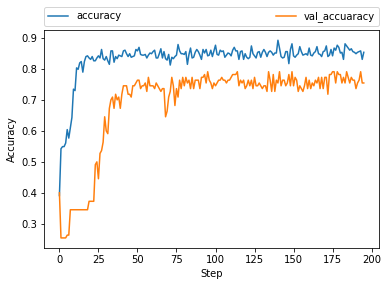

f1_score for each class
[0.81578947 0.68       0.71428571]
Global f1_score
0.7351330881949399
Global accuracy
0.7299270072992701


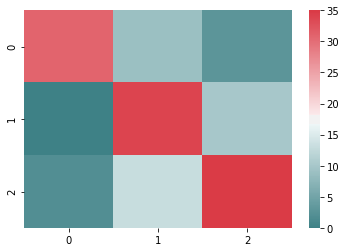

In [19]:
plot_accuracy(history)
test_metrics(model, y_test, X_test)

## CNN1 + Autoencoder

We will now use the best out of our tuned Networks (CNN1) and try to apply an autoencoder on its input. An autoencoder is a neural network that can be used for feature extraction: it reduces the dimensions of an input while keeping all informations, making it easier for the following classifier to learn. We are using the autoencoder on slices of 200 samples with a 50 samples shift, as before, which gave us the best results. The autoencoder transforms this input in a smaller vector of 100*1 samples instead of 200*2.

Epoch 1/200
35/35 - 0s - loss: 0.2164 - val_loss: 0.1474
Epoch 2/200
35/35 - 0s - loss: 0.0324 - val_loss: 0.1329
Epoch 3/200
35/35 - 0s - loss: 0.0204 - val_loss: 0.0897
Epoch 4/200
35/35 - 0s - loss: 0.0114 - val_loss: 0.0337
Epoch 5/200
35/35 - 0s - loss: 0.0118 - val_loss: 0.0142
Epoch 6/200
35/35 - 0s - loss: 0.0111 - val_loss: 0.0122
Epoch 7/200
35/35 - 0s - loss: 0.0095 - val_loss: 0.0090
Epoch 8/200
35/35 - 0s - loss: 0.0071 - val_loss: 0.0090
Epoch 9/200
35/35 - 0s - loss: 0.0077 - val_loss: 0.0059
Epoch 10/200
35/35 - 0s - loss: 0.0072 - val_loss: 0.0069
Epoch 11/200
35/35 - 0s - loss: 0.0066 - val_loss: 0.0058
Epoch 12/200
35/35 - 0s - loss: 0.0052 - val_loss: 0.0051
Epoch 13/200
35/35 - 0s - loss: 0.0068 - val_loss: 0.0056
Epoch 14/200
35/35 - 0s - loss: 0.0054 - val_loss: 0.0207
Epoch 15/200
35/35 - 0s - loss: 0.0086 - val_loss: 0.0186
Epoch 16/200
35/35 - 0s - loss: 0.0100 - val_loss: 0.0132
Epoch 17/200
35/35 - 0s - loss: 0.0049 - val_loss: 0.0043
Epoch 18/200
35/35 - 0s

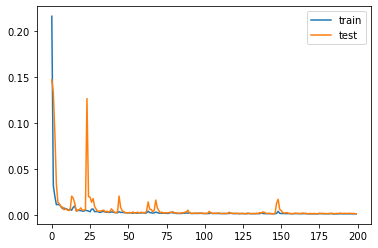

In [61]:
from matplotlib import pyplot
#X_train, X_test, y_train, y_test, input_shape, batch_size=data_preparation_nn(idata, 'slice')
input_shape=(200,2)

# define encoder
n_inputs=200
visible = layers.Input(shape=(input_shape))
# encoder level 1
e=layers.Flatten()(visible)
e = layers.Dense(n_inputs*2)(e)
e = layers.BatchNormalization()(e)
e = layers.LeakyReLU()(e)
# encoder level 2
e = layers.Dense(n_inputs)(e)
e = layers.BatchNormalization()(e)
e = layers.LeakyReLU()(e)
# bottleneck
n_bottleneck = round(float(n_inputs) )
bottleneck = layers.Dense(n_bottleneck)(e)
# define decoder, level 1
d = layers.Dense(n_inputs)(bottleneck)
d = layers.BatchNormalization()(d)
d = layers.LeakyReLU()(d)
# decoder level 2
d = layers.Dense(n_inputs*2)(d)
d = layers.BatchNormalization()(d)
d = layers.LeakyReLU()(d)
# output layer
d = layers.Dense(n_inputs*2, activation='linear')(d)
output=layers.Reshape(input_shape)(d)
# define autoencoder model
model = tf.keras.models.Model(inputs=visible, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=200, batch_size=16, verbose=2, validation_data=(X_test,X_test))
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# define an encoder model (without the decoder)
encoder = tf.keras.models.Model(inputs=visible, outputs=bottleneck)
# save the encoder to file
encoder.save('encoder.h5')

In [67]:
from tensorflow.keras.models import load_model
input_shape=(200,2)

#X_train, X_test, y_train, y_test, input_shape, batch_size=data_preparation_nn(idata, 'slice')

# load the model from file
encoder = load_model('encoder.h5')
# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)


X_train_encode=X_train_encode.reshape((X_train_encode.shape[0],X_train_encode.shape[1],1))
X_test_encode=X_test_encode.reshape((X_test_encode.shape[0],X_test_encode.shape[1],1))
print(X_train_encode.shape)
input_shape=(200,1)

steps=300
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=100)

model = models.Sequential()
model.add(layers.BatchNormalization(input_shape=input_shape))
model.add(layers.GaussianNoise(0.1))

for i in range(1):
    model.add(layers.Conv1D(filters=60, kernel_size=(2), padding='valid',activation='relu'))
    model.add(layers.Conv1D(filters=120, kernel_size=(8), padding='valid',activation='tanh'))
    model.add(layers.MaxPooling1D((2)))

model.add(layers.Dense(units=256))

model.add(layers.Dense(units=128))


model.add(layers.Flatten())
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer=optimizers.Adam(learning_rate = 0.0001),
          loss=tf.keras.losses.categorical_crossentropy,
          metrics=['accuracy'])

history=model.fit(X_train_encode, y_train, batch_size=batch_size, epochs=steps, verbose=1, validation_split=0.2,
                 callbacks=[callback])


(547, 200, 1)
Epoch 1/300
17/17 [==============================] - 0s 19ms/step - loss: 1.0723 - accuracy: 0.4302 - val_loss: 1.0556 - val_accuracy: 0.4545
Epoch 2/300
17/17 [==============================] - 0s 8ms/step - loss: 1.0251 - accuracy: 0.5126 - val_loss: 1.0637 - val_accuracy: 0.4455
Epoch 3/300
17/17 [==============================] - 0s 8ms/step - loss: 1.0060 - accuracy: 0.5423 - val_loss: 1.0408 - val_accuracy: 0.4455
Epoch 4/300
17/17 [==============================] - 0s 10ms/step - loss: 0.9886 - accuracy: 0.5355 - val_loss: 1.0469 - val_accuracy: 0.4545
Epoch 5/300
17/17 [==============================] - 0s 10ms/step - loss: 0.9822 - accuracy: 0.5378 - val_loss: 1.0334 - val_accuracy: 0.4636
Epoch 6/300
17/17 [==============================] - 0s 9ms/step - loss: 0.9716 - accuracy: 0.5400 - val_loss: 1.0315 - val_accuracy: 0.4818
Epoch 7/300
17/17 [==============================] - 0s 9ms/step - loss: 0.9542 - accuracy: 0.5446 - val_loss: 1.0343 - val_accuracy: 0.4

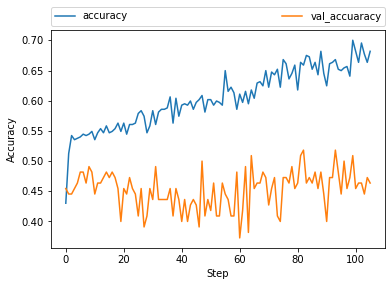

f1_score for each class
[0.46341463 0.39506173 0.52252252]
Global f1_score
0.4630340981299381
Global accuracy
0.46715328467153283


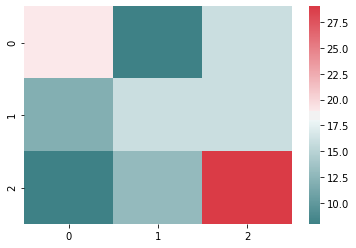

In [68]:
plot_accuracy(history)
test_metrics(model, y_test, X_test_encode)